In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
!pip install nltk

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import plotly.graph_objects as go
import itertools
import re

from sklearn.model_selection import train_test_split
from pprint import pprint
from wordcloud import WordCloud
from collections import Counter
from plotly.subplots import make_subplots
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import confusion_matrix, classification_report
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer


RANDOM_SEED = 1129
tf.keras.utils.set_random_seed(RANDOM_SEED)

In [37]:
df = pd.read_csv("/content/drive/MyDrive/seminar/tripadvisor_hotel_reviews.csv")
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [ ]:
df["Rating"].value_counts()

,count
Rating,
5,9054
4,6039
3,2184
2,1793
1,1421


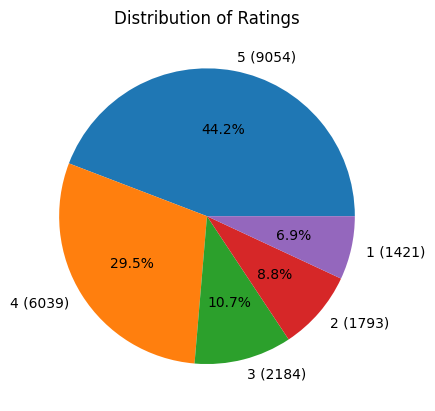

In [ ]:
rating_counts = df["Rating"].value_counts()

# Create a pie plot
plt.pie(rating_counts, labels=[f"{label} ({count})" for label, count in zip(rating_counts.index, rating_counts)], autopct='%1.1f%%')
plt.title("Distribution of Ratings")
plt.show()

<ipython-input-8-3e8060c8080c>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Rating", palette="viridis").set_title("Distribution of ratings")
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: W

Text(0.5, 1.0, 'Distribution of ratings')

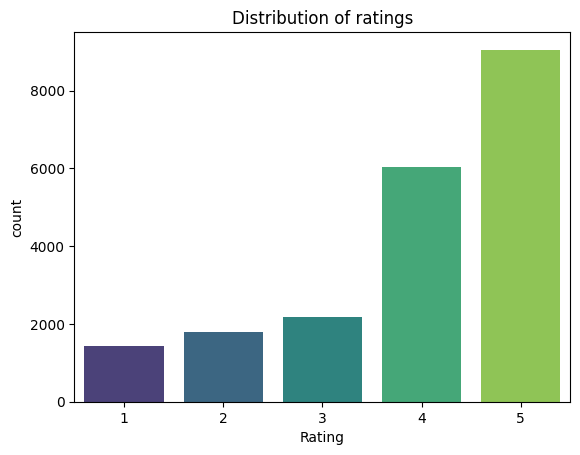

In [ ]:
sns.countplot(data=df, x="Rating", palette="viridis").set_title("Distribution of ratings")

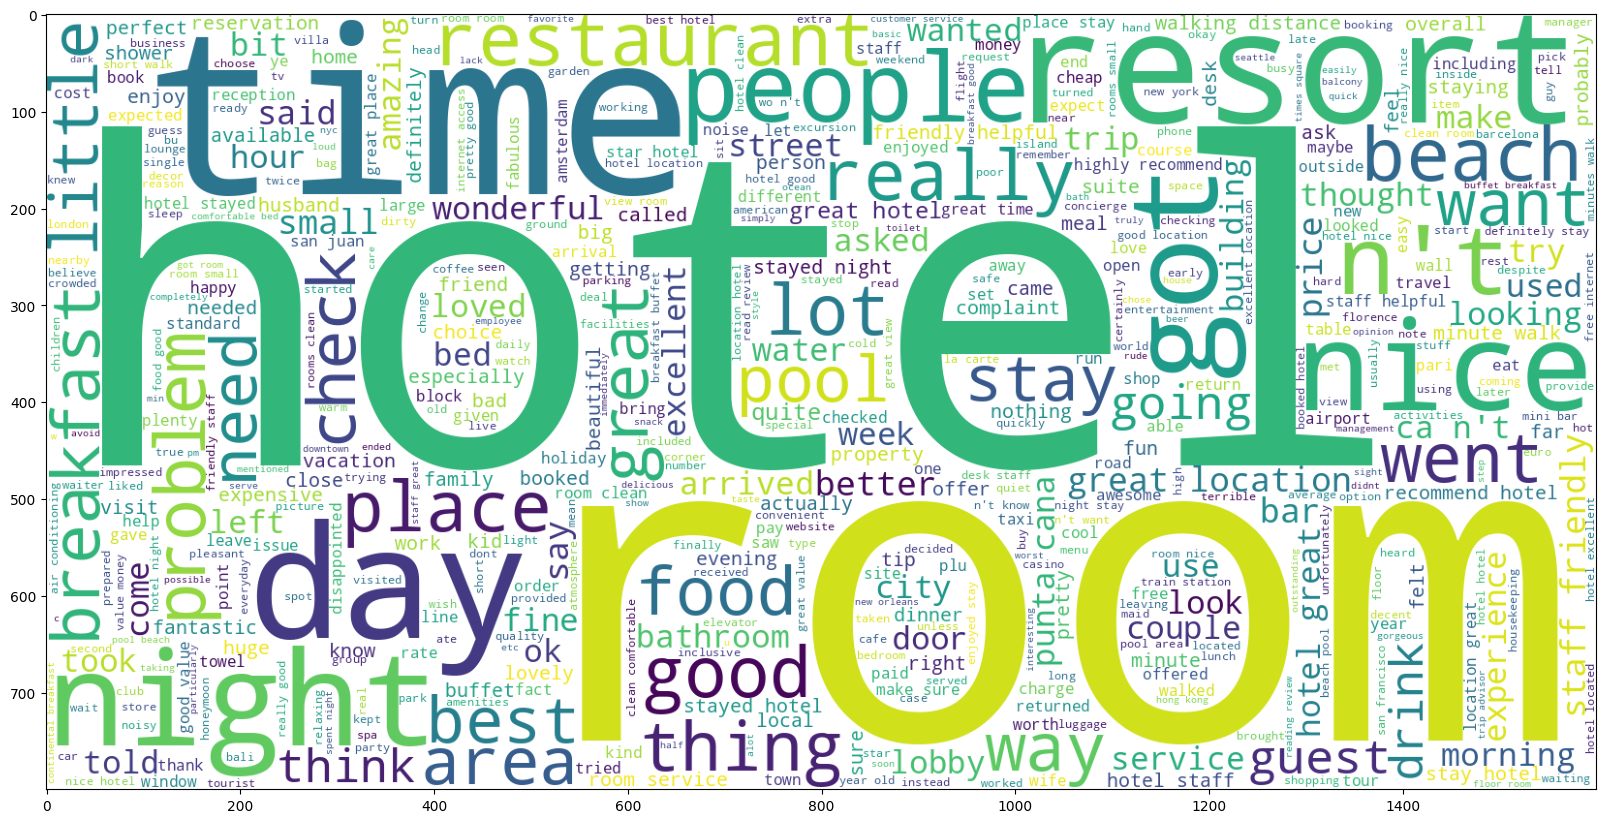

In [ ]:
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, min_font_size=10, height=800, width=1600,
               background_color="white", colormap="viridis").generate(" ".join(df["Review"]))

plt.imshow(wc)

In [ ]:
texts = df["Review"]
new = texts.str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]
counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word, count in most[:30]:
    x.append(word)
    y.append(count)

fig = go.Figure(go.Bar(
            x=y,
            y=x,
            orientation='h',  marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),
    name='Most common Word',))

fig.update_layout( title={
        'text': "Most Common Words",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ))

fig.show()

In [ ]:
chars = set()

for item in df["Review"]:
    chars = chars.union(item)

chars = sorted(chars)

print(chars)

[' ', "'", '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '=', '\\', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '~', '\x81', '\x82', '\x85', '\x8a', '\x8c', '\x8d', '\x8e', '\x8f', '\x90', '\x91', '\x93', '\x94', '\x95', '\x96', '\x99', '\x9d', '\xa0', '¢', '£', '©', '«', '±', '´', 'µ', '¾', 'À', 'Â', 'Ä', 'Ç', 'È', 'Ù', 'Û', 'Ü', 'à', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'î', 'ö']


In [ ]:
def find_review_by_character(c):
    for review in df["Review"]:
        if c in review and len(review) < 1000:
            return review

# Print a review for each non-English character
for c in ['À', 'Â', 'Ä', 'Ç', 'È', 'Ù', 'Û', 'Ü', 'à', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'î', 'ö']:
    pprint(find_review_by_character(c))
    print()

('breakfast disaster compared palace hotels paris traditional raphael bristol '
 'original interior old-fashioned service not corporate hip like luxurious '
 'private mansion.the room junior suite large standard luxurious bathroom '
 'renovated, 600___ night room little worn upgrading necessary comfortable '
 'furniture flat screen tv hifi etc.the reason rating hotel stars breakfast '
 '36___ low-quality limited buffet, rapha_À_l good chef lunch dinner charge '
 'meal day, reason not return,  ')

None

('wife just returned 5-day new years getaway new orleans want real feel french '
 'quarter highly suggest place d__Ç_©\x9drmes, no cookie cutter chain hotel, '
 'splendid property series buildings surround beautiful courtyard, no rooms '
 'quite hotel fits european charm surrounds enjoying french quarter, room huge '
 'sitting area sink comfortable king sized bed adjacent room, spent little '
 'time room time did spend clean room pleasant comfortable accommodating '
 'needs.what trip pla

In [38]:
def _get_top_ngram(corpus, n=None):
    #getting top ngrams
    vec = CountVectorizer(ngram_range=(n, n),
                          max_df=0.9,
                          ).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:15]
# Show most common 3-grams

fig = make_subplots(rows=1, cols=1)

texts = df["Review"]

new = texts.str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]

top_n_bigrams = _get_top_ngram(texts, 3)[:15]
x, y = map(list, zip(*top_n_bigrams))

fig.add_trace(go.Bar(
            x=y,
            y=x,
            orientation='h', type="bar",
    name="3-grams", marker=dict(color="lightgreen")), 1, 1),

fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common trigrams</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ))

fig.show()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df["Review"], df["Rating"], test_size=0.1, random_state=RANDOM_SEED)

# Sparse categorical crossentropy needs labels between 0 and N-1, so we need to subtract 1 from the ratings
y_train -= 1
y_val -= 1

In [ ]:
tmp_train_ds = tf.data.Dataset.from_tensor_slices(X_train)

tmp_vectorize = tf.keras.layers.TextVectorization()

tmp_vectorize.adapt(tmp_train_ds)

vocab_size = tmp_vectorize.vocabulary_size()
print(f"Vocab size before preprocessing: {vocab_size}")

In [ ]:
stemmer = SnowballStemmer("english")

def custom_preprocessing(text):
    # Stem words to reduce the number of distinct words - this should reduce overfitting
    text = " ".join(stemmer.stem(word) for word in text.split())
    # Ensure the comma (sentence separator) gets its own token and is not stripped out
    text = re.sub(r', ', r' newsentence ', text)
    return text

In [ ]:
X_train = X_train.apply(custom_preprocessing)
X_val = X_val.apply(custom_preprocessing)

In [ ]:
tmp_train_ds = tf.data.Dataset.from_tensor_slices(X_train)

tmp_vectorize = tf.keras.layers.TextVectorization()

tmp_vectorize.adapt(tmp_train_ds)

vocab_size = tmp_vectorize.vocabulary_size()
print(f"Vocab size after preprocessing: {vocab_size}")

In [ ]:
batch_size = 32
VOCAB_TOKENS = 50000

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(len(X_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_text = train_ds.map(lambda text, labels: text)

vectorize = tf.keras.layers.TextVectorization(max_tokens=VOCAB_TOKENS)

vectorize.adapt(train_text)

vocab_size = vectorize.vocabulary_size()
print(f"Total distinct words: {vocab_size}")

Total distinct words: 50000


In [ ]:
epochs = 25

def fit_model(model, train_ds, val_ds, fold_no):
    # Define the path to save the best model for each fold
    checkpoint_filepath = f'/content/drive/MyDrive/seminar/best_model.keras'

    # Add ModelCheckpoint callback to save the best model for each fold
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                             monitor='val_accuracy',
                                                             save_best_only=True,
                                                             save_weights_only=False,
                                                             mode='max',
                                                             verbose=1)

    # Define EarlyStopping callback
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=4, monitor="val_accuracy")
    return model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping_callback, checkpoint_callback])

def plot_metrics(history):
    metrics = pd.DataFrame(history.history)
    metrics[['accuracy', 'val_accuracy']].plot()
    metrics[['loss', 'val_loss']].plot()

Epoch 1/25
575/577 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4285 - loss: 1.5094
Epoch 1: val_accuracy improved from -inf to 0.44461, saving model to /content/drive/MyDrive/seminar/best_model.keras
577/577 ━━━━━━━━━━━━━━━━━━━━ 26s 35ms/step - accuracy: 0.4286 - loss: 1.5091 - val_accuracy: 0.4446 - val_loss: 1.3509
Epoch 2/25
575/577 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4348 - loss: 1.3398
Epoch 2: val_accuracy improved from 0.44461 to 0.45193, saving model to /content/drive/MyDrive/seminar/best_model.keras
577/577 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.4348 - loss: 1.3395 - val_accuracy: 0.4519 - val_loss: 1.1165
Epoch 3/25
577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4640 - loss: 1.1320
Epoch 3: val_accuracy improved from 0.45193 to 0.46462, saving model to /content/drive/MyDrive/seminar/best_model.keras
577/577 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.4640 - loss: 1.1320 - val_accuracy: 0.4646 - val_loss: 1.0467
Epoch 4/25
577/577 ━━━━━━

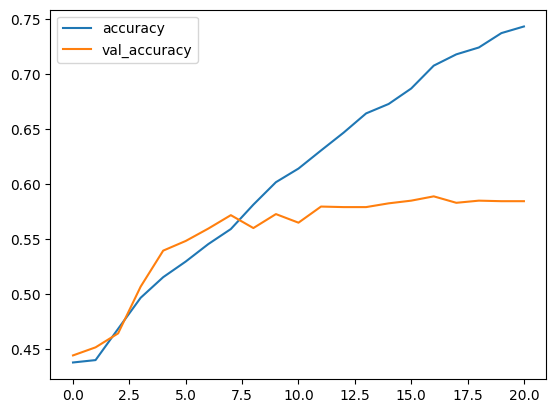

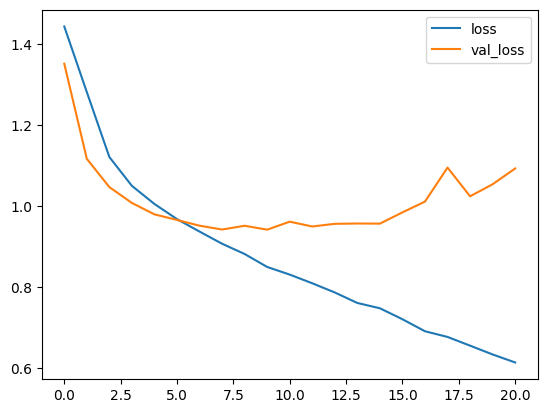

In [ ]:
model = tf.keras.models.Sequential([
    vectorize,
    tf.keras.layers.Embedding(vocab_size, 8),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = fit_model(model, train_ds, val_ds,1)
print(f"\n***Final val_accuracy: {history.history['val_accuracy'][-1]:.2%}***\n")

plot_metrics(history)

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


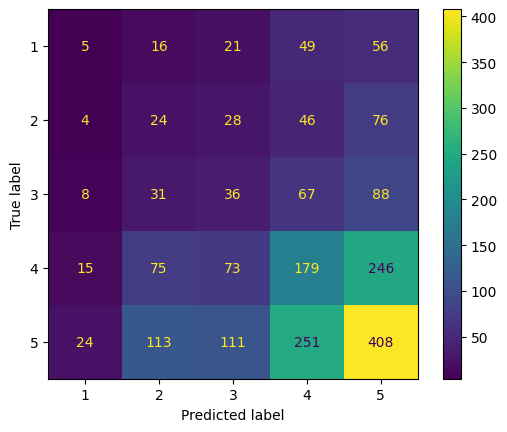

In [ ]:
val_text = val_ds.map(lambda text, labels: text)
model = tf.keras.models.load_model('/content/drive/MyDrive/seminar/best_model.keras')
pred = model.predict(val_text)
true_labels = y_val
pred_labels = np.argmax(pred, axis=-1)

cm = confusion_matrix(true_labels, pred_labels)
cm_disp = ConfusionMatrixDisplay(cm, display_labels=[1, 2, 3, 4, 5])
cm_disp.plot()

In [ ]:
# Save some incorrect predictions as a csv

num_samples = 20

df_incorrect = pd.DataFrame(columns=["Review", "True label", "Predicted label"])

for review_batch, label_batch in val_ds:
    pred_batch = tf.argmax(model.predict(review_batch), axis=-1)
    incorrect_flags = (pred_batch != label_batch)
    incorrect_reviews = review_batch[incorrect_flags]
    df_incorrect = pd.concat(
        [
            df_incorrect,
            pd.DataFrame(
                {
                    "Review": review_batch[incorrect_flags],
                    "True label": label_batch[incorrect_flags] + 1,
                    "Predicted label": pred_batch[incorrect_flags] + 1
                }
            )
        ],
        ignore_index=True
    )

    if df_incorrect.shape[0] >= num_samples:
        break

df_incorrect = df_incorrect.iloc[:num_samples, :]
df_incorrect["Review"] = df_incorrect["Review"].astype(str)

df_incorrect.to_csv("/content/drive/MyDrive/seminar/incorrect.csv", index=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


In [ ]:
from sklearn.model_selection import KFold
import numpy as np
epochs = 20
batch_size = 32
VOCAB_TOKENS = 50000
# Number of splits
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

# Convert X and y to NumPy arrays
X = np.array(df["Review"])
y = np.array(df["Rating"])

# Loop for k-fold cross-validation
fold_no = 1
val_accuracies = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Sparse categorical crossentropy needs labels between 0 and N-1, so we need to subtract 1 from the ratings
    y_train -= 1
    y_val -= 1
    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(len(X_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Define or reinitialize your model here
    model = tf.keras.models.Sequential([vectorize,
    tf.keras.layers.Embedding(vocab_size, 8),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')])

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    # Train the model
    history = fit_model(model, train_ds, val_ds, fold_no)

    # Store the validation accuracy
    val_accuracies.append(max(history.history['val_accuracy']))

    print(f"Fold {fold_no} - Validation Accuracy: {val_accuracies[-1]}")
    fold_no += 1

# After the loop, you can compute the mean validation accuracy across all folds
mean_val_accuracy = np.mean(val_accuracies)
print(f"Mean Validation Accuracy across all folds: {mean_val_accuracy}")

Epoch 1/20
577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3665 - loss: 1.5400
Epoch 1: val_accuracy improved from -inf to 0.44244, saving model to /content/drive/MyDrive/seminar/best_model_1.keras
577/577 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.3665 - loss: 1.5399 - val_accuracy: 0.4424 - val_loss: 1.3604
Epoch 2/20
576/577 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4124 - loss: 1.3675
Epoch 2: val_accuracy improved from 0.44244 to 0.45707, saving model to /content/drive/MyDrive/seminar/best_model_1.keras
577/577 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.4124 - loss: 1.3674 - val_accuracy: 0.4571 - val_loss: 1.2243
Epoch 3/20
577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4480 - loss: 1.2274
Epoch 3: val_accuracy improved from 0.45707 to 0.48585, saving model to /content/drive/MyDrive/seminar/best_model_1.keras
577/577 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.4480 - loss: 1.2273 - val_accuracy: 0.4859 - val_loss: 1.1492
Epoch 4/20
576/577 